**First, pull in the CSV I scraped from the UNC-CH course registrar pdf.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fall19_courses = pd.read_csv("UNCfall19courses.csv")

df = fall19_courses["Time:"].str.split(r'[:,-]', expand=True)
df_start = (df[0] + df[1])
df_end =  (df[2] + df[3])


fall19_courses["start_time"] = df_start
fall19_courses["end_time"] = df_end

fall19_courses = fall19_courses.dropna(subset=['start_time'])
fall19_courses = fall19_courses.dropna(subset=['end_time'])
fall19_courses["start_time"] = fall19_courses["start_time"].astype(int)
fall19_courses["end_time"] = fall19_courses["end_time"].astype(int)

####### working with datetime
# fall19_courses["start_time"] = pd.to_datetime(fall19_courses["start_time"].astype(int), format="%H%M")
# fall19_courses["end_time"] = pd.to_datetime(fall19_courses["end_time"].astype(int), format="%H%M")

In [3]:
fall19_courses = fall19_courses[fall19_courses['Bldg:']!='TBA']
fall19_courses = fall19_courses[fall19_courses['Days:']!='TBA']
# print(fall19_courses.count())
fall19_courses.head()


Bldg: Room: Days:          Time:  Class Enrl Tot:  \
AAAD  130        Gardner  0308  TuTh  12:30 - 13:45               43   
      130       Phillips  0247  TuTh  09:30 - 10:45               42   
      130        Peabody  0311  TuTh  14:00 - 15:15               43   
      200        Peabody  0306  TuTh  14:00 - 15:15               36   
      201  Carolina Hall  0220   MWF  08:00 - 08:50               32   

           start_time  end_time  
AAAD  130        1230      1345  
      130         930      1045  
      130        1400      1515  
      200        1400      1515  
      201         800       850

**Optional: remove classes with over 50 or over 100 students.**

In [4]:
fall19_courses = fall19_courses[fall19_courses['Class Enrl Tot:'] < 100]
fall19_courses = fall19_courses[fall19_courses['Class Enrl Tot:'] < 50]
print(f'Courses with more than 100 students: {fall19_courses[fall19_courses["Class Enrl Tot:"] > 99].count()[0]}')
print(f'Courses with more than 50 students: {fall19_courses[fall19_courses["Class Enrl Tot:"] > 49].count()[0]}')

Courses with more than 100 students: 0
Courses with more than 50 students: 0


**Optional: reorganize classes so that they are more distributed throughout the day (i.e. add weeknight classes). Sample between classes between 1100 (11:00) and 1459 (2:59) and, conditional on the classes being less than 1.5 hours, sample 1/4 of these courses, and move the 1100 to 800 and for the others add five hours**



In [5]:

# sample_courses = fall19_courses.loc[fall19_courses['start_time'].isin(samp_times) & 
#                    (fall19_courses['end_time']-fall19_courses['start_time']<151)]['Room:'].count()


# sample_df = fall19_courses[fall19_courses['start_time'].isin(samp_times) & 
#                    (fall19_courses['end_time']-fall19_courses['start_time']<151)].sample(n=sample_courses//3)

########################################################################################

for index, row in fall19_courses.iterrows():
    if 1100 <= row['start_time'] <=1459 and (row['end_time']-row['start_time']<151):
        if np.random.randint(1,5) == 3:
            if row['start_time'] == 1100:
                fall19_courses.at[index,'start_time'] = row['start_time'] - 300
                fall19_courses.at[index,'end_time'] = row['end_time'] - 300
                
            else:   
                fall19_courses.at[index,'start_time'] = row['start_time'] + 500
                fall19_courses.at[index,'end_time'] = row['end_time'] + 500

# save to csv
# fall19_courses.to_csv('UNCfall19coursesReorg.csv')
########################################################################################


**Make initial summation with a groupby.**

Return a random sample of rows from the dataframe to check results.

In [6]:
geodata_fall19 = fall19_courses.groupby(['Bldg:','Days:','start_time','end_time'])['Class Enrl Tot:'].sum().reset_index(name ='Population')

# geodata_fall19[geodata_fall19['Bldg:']=='Phillips']

geodata_fall19.sample(n=10, random_state=0)


,Bldg:,Days:,start_time,end_time,Population
1451,Phillips,M,1730,1820,145
652,Global Center,TuTh,1900,2015,25
792,Hamilton Hall,Tu,1530,1800,14
17,Alumni,M,1615,1705,113
1453,Phillips,MTuWTh,1605,1655,36
688,Graham Memorial,TuTh,800,915,18
737,Greenlaw,TuTh,1700,1815,26
758,Hamilton Hall,F,1720,1810,115
579,Genome Sciences Buil,F,1930,2020,37
618,Genome Sciences Buil,TuTh,1900,2015,13


**We still need to group the rows by days of the week (M, T, W, Th, F) and put into regular time intervals.**

Note: I include a groupby to ignore cross listed courses so we avoid double counting these courses. However, this would also remove labs that are listed in the same classroom but actually take place in a laboratory building.

In [8]:
# organize by day of week into separate day names

monday = geodata_fall19[(geodata_fall19['Days:'].str.contains('M'))
                               ].groupby(['Bldg:','Days:','start_time', 'end_time']
                                   ).sum().reset_index()

tuesday = geodata_fall19[(geodata_fall19['Days:'].str.contains('Tu'))
                               ].groupby(['Bldg:','Days:','start_time', 'end_time']
                                   ).sum().reset_index()


wednesday = geodata_fall19[(geodata_fall19['Days:'].str.contains('W'))
                               ].groupby(['Bldg:','Days:','start_time', 'end_time']
                                   ).sum().reset_index()

thursday = geodata_fall19[(geodata_fall19['Days:'].str.contains('Th'))
                               ].groupby(['Bldg:','Days:','start_time', 'end_time']
                                   ).sum().reset_index()

friday = geodata_fall19[(geodata_fall19['Days:'].str.contains('F'))
                               ].groupby(['Bldg:','Days:','start_time', 'end_time']
                                   ).sum().reset_index()

# friday.head(50)

In [9]:
# organize the student population in buildings, for each day of the week, by the time

##################
# should re-do this using datetime, like this: 
# start_date = datetime.strptime(str(700),"%H%M")
# end_date = datetime.strptime(str(2300),"%H%M")
# delta = datetime.timedelta(minutes=15)

# while start_date <= end_date:
#     monday_time[start_date] = monday[(monday['start_time'] <= start_date) 
#                                      & (monday['end_time'] >= start_date)]['Population'].sum()
#     start_date += delta
###################


times = [time for time in range(700, 2300, 5) if time % (10**2) in [0, 15, 30, 45, 60]]


monday_time = {}
for time in times:
    monday_time[time] = monday[(monday['start_time'] <= time) & (monday['end_time'] >= time)]['Population'].sum()

tuesday_time = {}
for time in times:
    tuesday_time[time] = tuesday[(tuesday['start_time'] <= time) & (tuesday['end_time'] >= time)]['Population'].sum()
    
wednesday_time = {}
for time in times:
    wednesday_time[time] = wednesday[(wednesday['start_time'] <= time) & (wednesday['end_time'] >= time)]['Population'].sum()

thursday_time = {}
for time in times:
    thursday_time[time] = thursday[(thursday['start_time'] <= time) & (thursday['end_time'] >= time)]['Population'].sum()
    
friday_time = {}
for time in times:
    friday_time[time] = friday[(friday['start_time'] <= time) & (friday['end_time'] >= time)]['Population'].sum()

dict_list = [monday_time, tuesday_time, wednesday_time, thursday_time, friday_time]

**Finally, we can make plots of the total student population to get an idea of how extended hours and/or limiting the size of courses will look with respect to student-to-student spread of COVID-19.**

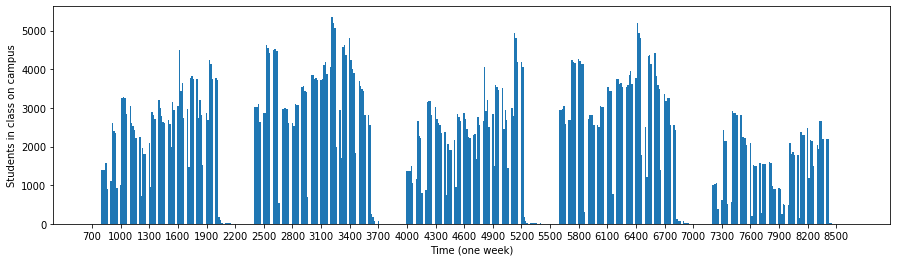

In [10]:
import math

y = []
x = []

add_on = 3000
counter = 0
for day in dict_list:
    add_on = 1600*counter
    for time in times:
        x.append(time+add_on)
        y.append(day[time].sum())
    counter += 1

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
ax.bar(x, y, width=15)
plt.xticks(x[::15])
plt.ylabel('Students in class on campus')
plt.xlabel('Time (one week)')
plt.show()

**Another question: what is the classroom utilization?**

Consider two potential useful ways of answering this question:
1. How often is this classroom _used_?
2. How far below is the classroom below _maximum occupancy_?

We consider the first question of how often this classroom is used.
We performed this analysis in Excel. 

**Another question: what happens when we make sure that there is at least 30 mins between each class?**

See the notebook SpreadClasses30Mins.ipynb for implementation, visualization coming. 